# Explore the Model Performance in Inference and Test

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
from pathlib import Path
import matplotlib.patches as patches
import numpy as np
import sys
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import Dataset, DataLoader

sys.path.append('/dss/dsshome1/0A/di38tac/DOTA-Net/code')
from utils.training import get_best_checkpoint_path
from utils.dataset import DOTA_preprocessed, val_transforms, collate_fn


In [2]:
DOTA_SET = 'dota-subset' # possible values: dota-subset, dota
SPLIT = 'test-dev' # possible values: train, val, test-dev

ROOT = Path("/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022")
home = Path("/dss/dsshome1/0A/di38tac/DOTA-Net")

USER = "di38tac"
USER_PATH = ROOT / f"users/{USER}"
DOTA_ROOT = USER_PATH / "DATA" / "SlidingWindow" / DOTA_SET / SPLIT 
INFERENCE_DIR = DOTA_ROOT / "Inference"

model_name = 'FasterRCNN'

## or upload model to github
EXPERIMENT_GROUP = "dota_FasterRCNN" # subfolder for model
EXPERIMENT_ID = "exp_003"
EXPERIMENT_DIR = home / model_name / f"experiments/{EXPERIMENT_GROUP}" / EXPERIMENT_ID

exp_fls = os.listdir(EXPERIMENT_DIR)
checkpoint = EXPERIMENT_DIR / exp_fls[0]

best_checkpoint_path = get_best_checkpoint_path(str(checkpoint))

In [16]:
out_path = INFERENCE_DIR / f"{model_name}-{EXPERIMENT_ID}_predictions.csv"
predictions_df = pd.read_csv(out_path)

## Visualize some predicitons
The test-dev set is utilized to visually interpret the performance of the model. Bounding Boxes are colored according to their class id. Bounding Boxes with a score lower than 0.5 are visualized with an alpha value of 0.5. See therefore the `plot_sample` function.

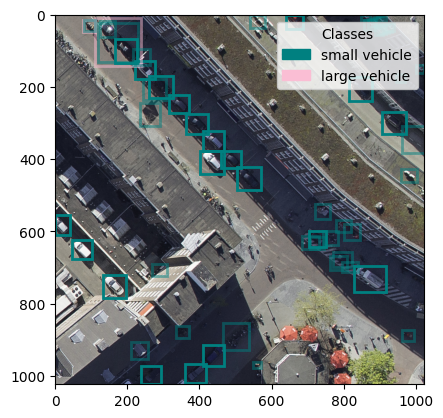

In [39]:
from utils.visualization import plot_sample

plot_sample(predictions_df, DOTA_ROOT)

## Evaluation of per Class Accuracy
As the model performs probably differently per class in terms of accuracy, the class accuracy was evaluated on the validation split of the dota-subset, as this was not used in training and has annotations (other than the test-dev split).

Therefore the model is loaded again from the checkpoint and the dataset and dataloader are initalized.

In [6]:
# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

best_checkpoint_path = get_best_checkpoint_path(str(checkpoint))
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 19
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

checkpoint = torch.load(best_checkpoint_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [7]:
# setup dataset and dataloader
DOTA_SET = 'dota'
SPLIT = 'val'
DOTA_ROOT = USER_PATH / "DATA"/ "SlidingWindow" / DOTA_SET

test_dataset = DOTA_preprocessed(
    csv_file=DOTA_ROOT / 'val' / "ann/annotations.csv",
    root_img_dir=DOTA_ROOT / 'val' / "img",
    transform=val_transforms(),
    difficult=False
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False
)

In [8]:
from collections import defaultdict
from utils.training import prepare_map_targets, prepare_map_predictions
from torchmetrics.detection.mean_ap import MeanAveragePrecision
# Define IoU threshold for accuracy
iou_threshold = 0.5
VAL_SCORE_THRESHOLD = 0.5

# Per-class tracking
correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

# Initialize Mean Average Precision metric
mAP = MeanAveragePrecision(iou_type="bbox").to(device)

def calculate_iou(box1, box2):
    """Computes IoU between two bounding boxes in format [x1, y1, x2, y2]."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0

# Evaluate Model
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output, target in zip(outputs, targets):
            pred_boxes = output["boxes"].cpu().numpy()
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            gt_boxes = target["boxes"].numpy()
            gt_labels = target["labels"].numpy()

            pred_data = [{
                "boxes": torch.tensor(pred_boxes, dtype=torch.float32).to(device),
                "scores": torch.tensor(pred_scores, dtype=torch.float32).to(device),
                "labels": torch.tensor(pred_labels, dtype=torch.int64).to(device)
            }]
            gt_data = [{
                "boxes": torch.tensor(gt_boxes, dtype=torch.float32).to(device),
                "labels": torch.tensor(gt_labels, dtype=torch.int64).to(device)
            }]

            mAP.update(pred_data, gt_data)

            # Compute Per-Class Accuracy
            for gt_box, gt_label in zip(gt_boxes, gt_labels):
                total_per_class[gt_label] += 1
                
                # Find best matching prediction
                best_iou = 0
                best_pred_idx = -1

                for i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):
                    if pred_label == gt_label:
                        iou = calculate_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_pred_idx = i

                if best_iou >= iou_threshold and best_pred_idx != -1:
                    correct_per_class[gt_label] += 1

# Compute Per-Class Accuracy
per_class_accuracy = {
    class_id: correct_per_class[class_id] / total_per_class[class_id]
    for class_id in total_per_class
}

# Compute mAP
map_result = mAP.compute()
map_value = map_result["map"].item()

# Print Results
print("\nPer-Class Accuracy:")
for class_id, acc in per_class_accuracy.items():
    print(f"Class {class_id}: Accuracy = {acc:.2%}")

print(f"\nMean Average Precision (mAP): {map_value:.4f}")


Per-Class Accuracy:
Class 11: Accuracy = 70.90%
Class 5: Accuracy = 88.57%
Class 3: Accuracy = 82.74%
Class 13: Accuracy = 80.17%
Class 4: Accuracy = 87.00%
Class 14: Accuracy = 79.21%
Class 7: Accuracy = 79.49%
Class 6: Accuracy = 66.49%
Class 10: Accuracy = 79.56%
Class 17: Accuracy = 85.92%
Class 9: Accuracy = 75.58%
Class 1: Accuracy = 93.83%
Class 15: Accuracy = 61.31%
Class 8: Accuracy = 73.90%
Class 2: Accuracy = 64.00%
Class 16: Accuracy = 14.29%
Class 18: Accuracy = 0.00%
Class 12: Accuracy = 59.80%

Mean Average Precision (mAP): 0.3468


In [9]:
# Save Results
df = pd.DataFrame(list(per_class_accuracy.items()), columns=["Class", "Accuracy"])
df["mAP"] = map_value  # Add mAP as an extra column
out_path = INFERENCE_DIR / 'eval'
os.makedirs(out_path, exist_ok=True)
df.to_csv(out_path / f"{EXPERIMENT_ID}_{DOTA_SET}_{SPLIT}_class_accuracy.csv", index=False)

print(f"Evaluation results saved to {out_path}")

Evaluation results saved to /dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di38tac/DATA/SlidingWindow/dota-subset/test-dev/Inference/eval


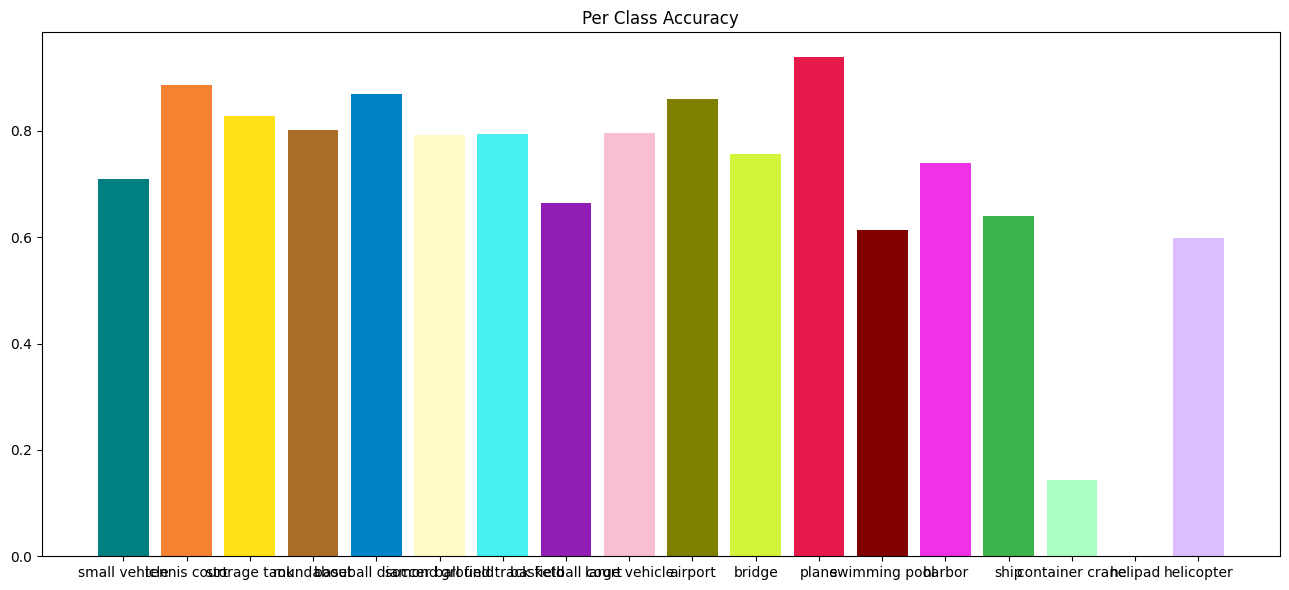

In [1]:
from utils.visualization import plot_class_accuracy
import pandas as pd

df_path = "/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di38tac/DATA/SlidingWindow/dota-subset/test-dev/Inference/eval/exp_003_dota_val_class_accuracy.csv"
df = pd.read_csv(df_path)
plot_class_accuracy(df)